# Predicting Drug Yield - Data Cleaning and Exploratory Data Analysis
This notebook cleaned the data and did some initial exploratory data analysis. This notebook works in conjunction with the other biologics modeling notebook.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
sns.set_context('notebook')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import scipy.stats as spStats

In [2]:
raw_df = pd.read_excel('Raw data.xlsx', sheetname='Study Data')

# Data Cleaning and Wrangling
Original dataframe is called **raw_df**. 

First, let's clean up all missing values, transform anything needed, add dummy variables, and change the name to **processed_df**.

After that, start dropping off the outliers.

In [3]:
raw_df.isnull().sum()

Month                        0
Year                         0
Week No.                     0
Date                         0
Lot Number                   0
Cut Lot Number               0
Bag/Bottle                   3
PCA (%)                      8
PPT G (kg)                   0
CPP (kg)                     0
g PPT G/kg CPP               0
Total Protein (g/dL)         0
CUNO Filt (kg)               0
VP (L)                       0
Diluted CPP (kg)             1
Dilution (kg)                0
CPP IgG before Fr1          14
Cuno IgG FP6                20
Diluted % Efficiency        15
CPP (L)                      0
G Conv (g IgG/Kg PPT G)      0
Yield CP (WT)                0
Yield_Label                  0
Yield_Label_2                0
Yield VP (WT)                1
I - Final pH                 4
I - Aging                   93
II+III After Alc pH          1
II+III After Alc Titer       1
II+III - Final pH            1
II+III - Aging              97
II+III Paste Wt              0
Buffer 1

In [4]:
Counter(raw_df.dropna()['Year'])

Counter({2014: 112, 2015: 226, 2016: 111})

In [5]:
print 'Length of raw data:',len(raw_df)
print 'Observation count per year for raw_df:',Counter(raw_df['Year'])
print 'Observation count per bag/bottle for raw_df:',Counter(raw_df['Bag/Bottle'])
print ''
print 'Length of raw_df.dropna():',len(raw_df.dropna())
print 'Observation count per year for raw_df.dropna():',Counter(raw_df.dropna()['Year'])
print 'Observation count per bag/bottle for raw_df.dropna():',Counter(raw_df.dropna()['Bag/Bottle'])

Length of raw data: 599
Observation count per year for raw_df: Counter({2015: 260, 2014: 215, 2016: 124})
Observation count per bag/bottle for raw_df: Counter({u'Bags': 336, u'Bottle': 204, u'Bags/NMF': 56, nan: 3})

Length of raw_df.dropna(): 449
Observation count per year for raw_df.dropna(): Counter({2015: 226, 2014: 112, 2016: 111})
Observation count per bag/bottle for raw_df.dropna(): Counter({u'Bags': 252, u'Bottle': 151, u'Bags/NMF': 46})


If I do an overall dropna(), I am losing about 100 observations for year 2014 and around 10% for 2015 and 2016. I feel comfortable with this data loss so I will proceed with an overall dropna().

In [6]:
raw_df = pd.read_excel('Raw data.xlsx', sheetname='Study Data')
raw_df = raw_df.dropna()
raw_df['Year']= raw_df['Year'].apply(str)
raw_df.reset_index(inplace=True,drop=True)
raw_df.head()

,Month,Year,Week No.,Date,Lot Number,Cut Lot Number,Bag/Bottle,PCA (%),PPT G (kg),CPP (kg),...,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT
0,1,2014,2,2014-01-06,LB1499004,LB149004,Bags,90.1,112.3,7479.7,...,6.54,4.48,6.98,0.662847,8.692500,7.024167,14.136389,10.084722,-0.001111,39.180278
1,1,2014,2,2014-01-08,LB1499007,LB149007,Bags,91.1,111.3,7477.7,...,6.41,4.77,6.83,0.362558,6.581667,12.799167,17.747778,7.583889,-0.001111,37.615833
2,1,2014,2,2014-01-09,LB1499010,LB149010,Bags,89.6,110.0,7417.4,...,6.57,4.2,6.9,0.442535,13.538889,6.866111,18.744444,7.042778,-0.001111,35.358056
3,1,2014,2,2014-01-09,LB1499013,LB149013,Bags/NMF,90.8,114.3,7342.8,...,6.5,4.25,6.94,0.691620,5.982222,6.271667,12.984722,6.517500,-0.001111,39.269444
4,1,2014,3,2014-01-10,LB1499016,LB149016,Bags,90.3,113.9,7398.1,...,6.49,4.4,6.99,0.727685,7.170000,8.272222,13.024444,6.097778,-0.001111,43.589167


In [7]:
# Through graphical exploration, I found out that the feature II+III - Aging needs some data cleaning.
# The data is sometimes stored as percentage of a 24-hour period (e.g. 0.25 = a quarter of a day), sometimes
# it's stored as hh:mm. 
tempList = []
raw_df['II+III - Aging'] = raw_df['II+III - Aging'].apply(str)
for i in raw_df['II+III - Aging']:
    if ':' in i:
        h,m = i.strip().split(':')
        tempHours = float(h) + (float(m) /60)
        tempList.append(tempHours)
    else:
        tempList.append(float(i)*24)
raw_df['II+III - Aging'] = tempList

raw_df[['I - Aging','Extract - Aging','G - Aging']] = raw_df[['I - Aging','Extract - Aging','G - Aging']].apply(lambda x: x*24)
raw_df.head()

,Month,Year,Week No.,Date,Lot Number,Cut Lot Number,Bag/Bottle,PCA (%),PPT G (kg),CPP (kg),...,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT
0,1,2014,2,2014-01-06,LB1499004,LB149004,Bags,90.1,112.3,7479.7,...,6.54,4.48,6.98,15.908333,8.692500,7.024167,14.136389,10.084722,-0.001111,39.180278
1,1,2014,2,2014-01-08,LB1499007,LB149007,Bags,91.1,111.3,7477.7,...,6.41,4.77,6.83,8.701389,6.581667,12.799167,17.747778,7.583889,-0.001111,37.615833
2,1,2014,2,2014-01-09,LB1499010,LB149010,Bags,89.6,110.0,7417.4,...,6.57,4.2,6.9,10.620833,13.538889,6.866111,18.744444,7.042778,-0.001111,35.358056
3,1,2014,2,2014-01-09,LB1499013,LB149013,Bags/NMF,90.8,114.3,7342.8,...,6.5,4.25,6.94,16.598889,5.982222,6.271667,12.984722,6.517500,-0.001111,39.269444
4,1,2014,3,2014-01-10,LB1499016,LB149016,Bags,90.3,113.9,7398.1,...,6.49,4.4,6.99,17.464444,7.170000,8.272222,13.024444,6.097778,-0.001111,43.589167


In [8]:
raw_df[['I - Aging','II+III - Aging','Extract - Aging','G - Aging']].describe()

,I - Aging,II+III - Aging,Extract - Aging,G - Aging
count,449.000000,449.000000,449.000000,449.000000
mean,8.808753,16.041277,3.121265,18.522094
std,7.388653,11.460087,0.748721,15.011769
min,0.850000,4.733333,2.116667,2.550000
25%,5.533333,7.500000,2.566667,3.650000
50%,6.500000,13.000000,3.150000,14.083333
75%,10.416667,21.500000,3.350000,30.350000
max,70.783333,91.066667,10.450000,84.583333


In [9]:
# Cleaning some more data...
raw_df['G - Init pH'] = raw_df['G - Init pH'].apply(str)
raw_df['G - titer'] = raw_df['G - titer'].apply(str)
raw_df['G - Final pH'] = raw_df['G - Final pH'].apply(str)

raw_df = raw_df[~raw_df['G - Init pH'].str.contains('\)')]
raw_df = raw_df[~raw_df['G - titer'].str.contains('\)')]
raw_df = raw_df[~raw_df['G - Final pH'].str.contains('is')]

raw_df['G - Init pH'] = raw_df['G - Init pH'].apply(float)
raw_df['G - titer'] = raw_df['G - titer'].apply(float)
raw_df['G - Final pH'] = raw_df['G - Final pH'].apply(float)


print 'Length of data:',len(raw_df)


Length of data: 425


# Features Exploration and Further Data Cleaning
In this section, the goal is to look at all the features and see which ones can be used as numerical or categorical features. Also, anything that needs transforming or adding dummy variables. I'll do it here too. It's a long list of features so this will be a big section.

In [10]:
# Using isnull().sum() instead of .columns gives you a vertical list of columns, which I prefer. 
# Also checks for any missed NA values.
raw_df.isnull().sum()

Month                      0
Year                       0
Week No.                   0
Date                       0
Lot Number                 0
Cut Lot Number             0
Bag/Bottle                 0
PCA (%)                    0
PPT G (kg)                 0
CPP (kg)                   0
g PPT G/kg CPP             0
Total Protein (g/dL)       0
CUNO Filt (kg)             0
VP (L)                     0
Diluted CPP (kg)           0
Dilution (kg)              0
CPP IgG before Fr1         0
Cuno IgG FP6               0
Diluted % Efficiency       0
CPP (L)                    0
G Conv (g IgG/Kg PPT G)    0
Yield CP (WT)              0
Yield_Label                0
Yield_Label_2              0
Yield VP (WT)              0
I - Final pH               0
I - Aging                  0
II+III After Alc pH        0
II+III After Alc Titer     0
II+III - Final pH          0
II+III - Aging             0
II+III Paste Wt            0
Buffer 1 Amt               0
Extraction Ratio           0
Extract - Fina

## Bag/Bottle
Our raw material comes in 3 flavors. I foresee that much of my feature analysis will be a cross examination with this feature.

Bag/Bottle  Bags  Bags/NMF  Bottle
Year                              
2014          62         9      41
2015         125        25      65
2016          56         7      35


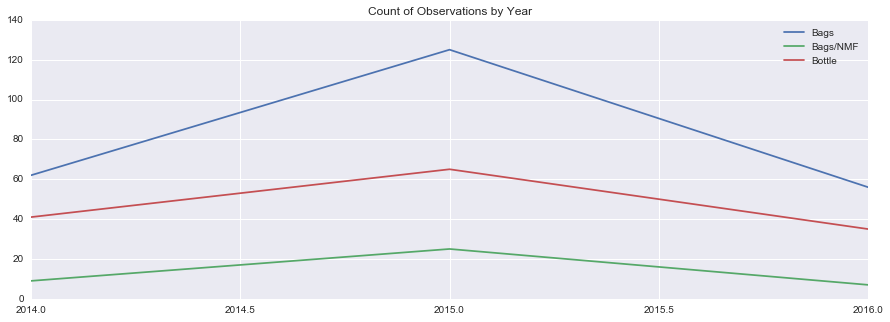

In [11]:
plt.figure(figsize=(15,5))
plt.plot(pd.crosstab(index=raw_df['Year'],columns=raw_df['Bag/Bottle'])['Bags'], label='Bags')
plt.plot(pd.crosstab(index=raw_df['Year'],columns=raw_df['Bag/Bottle'])['Bags/NMF'], label='Bags/NMF')
plt.plot(pd.crosstab(index=raw_df['Year'],columns=raw_df['Bag/Bottle'])['Bottle'], label='Bottle')
plt.legend()
plt.title('Count of Observations by Year')
plt.ticklabel_format(useOffset=False)

print pd.crosstab(index=raw_df['Year'],columns=raw_df['Bag/Bottle'])

## Helper Functions

In [12]:
def box_and_dist_graphs(df,feature):
    '''
    Takes in two arguments: (df=DataFrame, feature=str).
    Displays a bunch of seaborn charts.
    Returns None
    '''
    plt.figure()
    sns.boxplot(data=df,x='Bag/Bottle',y=feature,width=.5)
    
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.title('Bags')
    sns.distplot(df[df['Bag/Bottle']=='Bags'][feature],kde=False)
    plt.subplot(132)
    plt.title('Bags/NMF')
    sns.distplot(df[df['Bag/Bottle']=='Bags/NMF'][feature],kde=False)
    plt.subplot(133)
    plt.title('Bottle')
    sns.distplot(df[df['Bag/Bottle']=='Bottle'][feature],kde=False)
    return None

## CPP (kg)

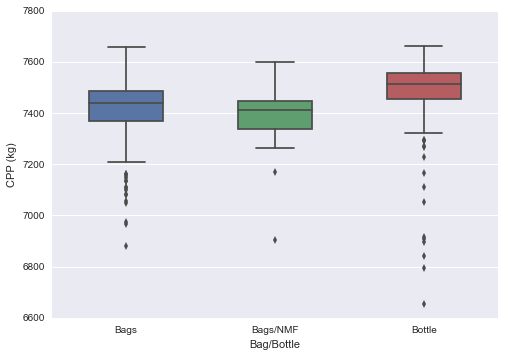

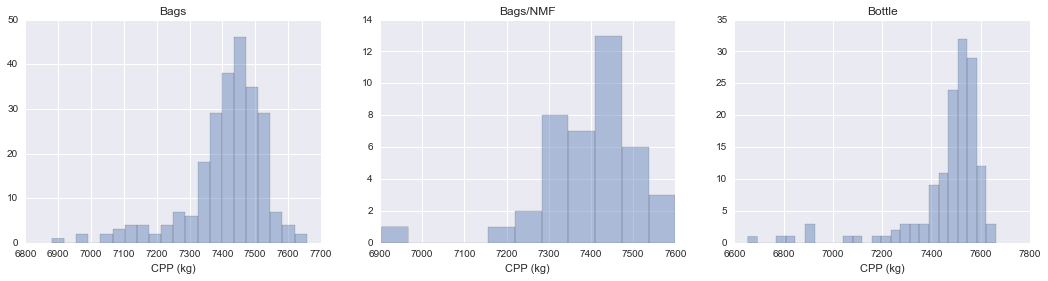

In [13]:
box_and_dist_graphs(df=raw_df,feature='CPP (kg)')

## CUNO Filt (kg)

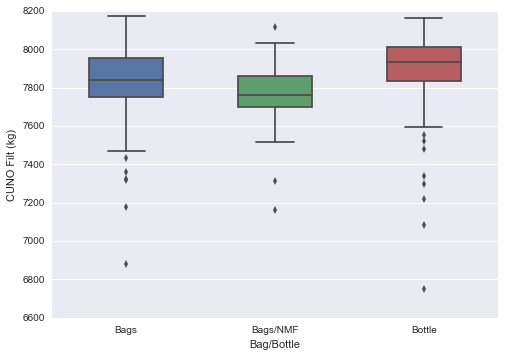

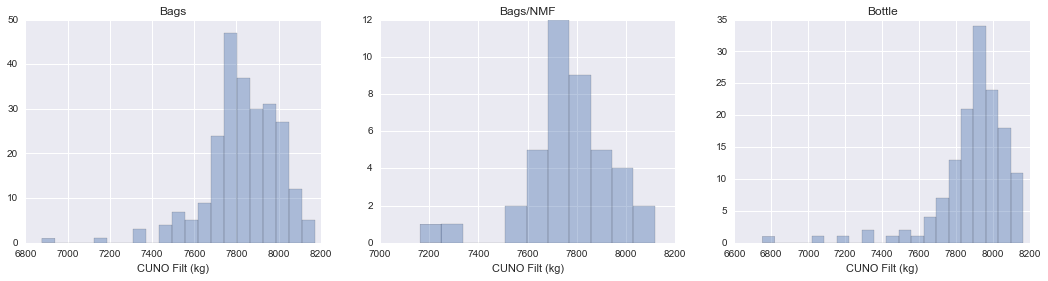

In [14]:
box_and_dist_graphs(raw_df,'CUNO Filt (kg)')

In [15]:
raw_df['CUNO Filt (kg)'].sort_values(ascending=True)
raw_df = raw_df[~raw_df.index.isin([67,130])]

## Diluted CPP (kg)

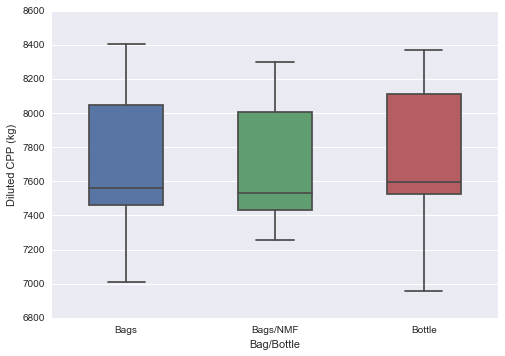

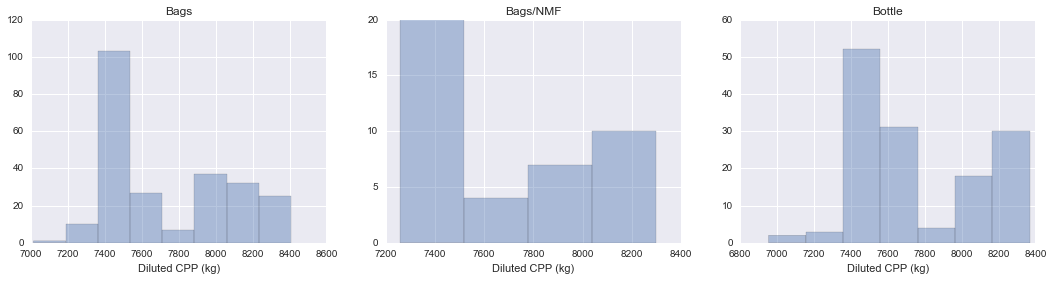

In [16]:
box_and_dist_graphs(raw_df,'Diluted CPP (kg)')

## Dilution (kg)

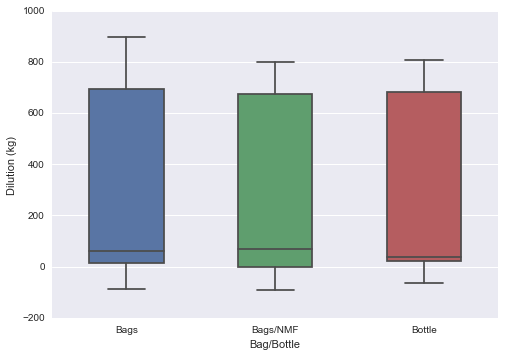

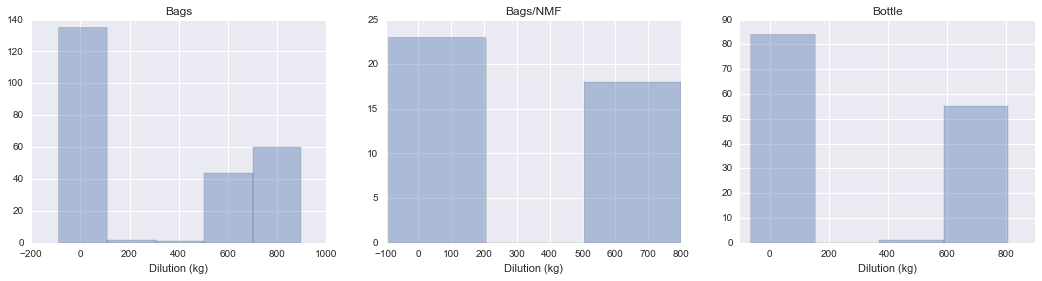

In [17]:
box_and_dist_graphs(raw_df,'Dilution (kg)')

## VP (L)

In [18]:
# box_and_dist_graphs(raw_df,'VP (L)')

## CPP IGG Before Fr1

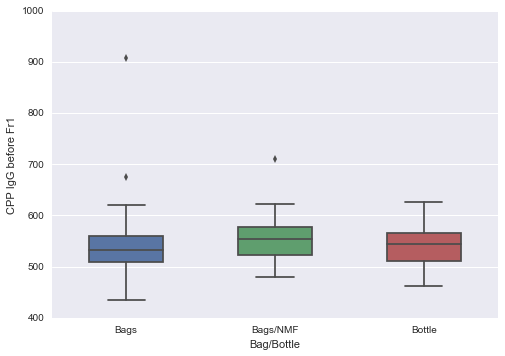

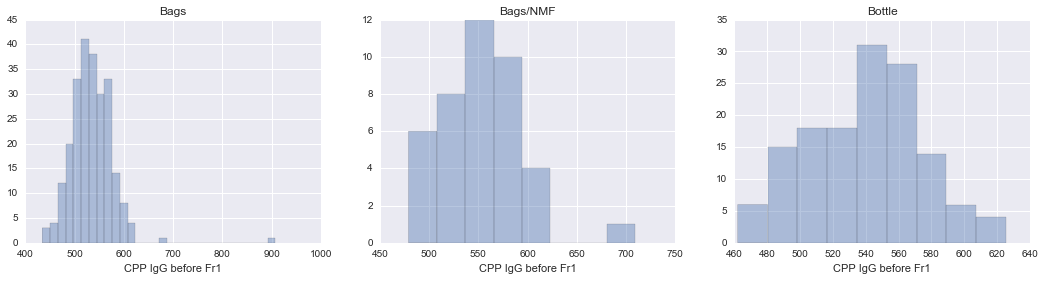

In [19]:
box_and_dist_graphs(raw_df,'CPP IgG before Fr1')

In [20]:
raw_df['CPP IgG before Fr1'].sort_values(ascending=False)
raw_df = raw_df[~raw_df.index.isin([56])]

## Cuno IgG FP6

In [21]:
# box_and_dist_graphs(raw_df,'Cuno IgG FP6')

## I - Final pH

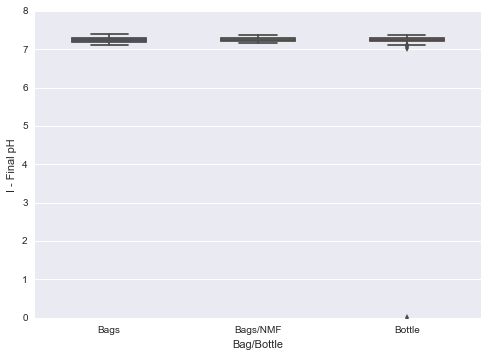

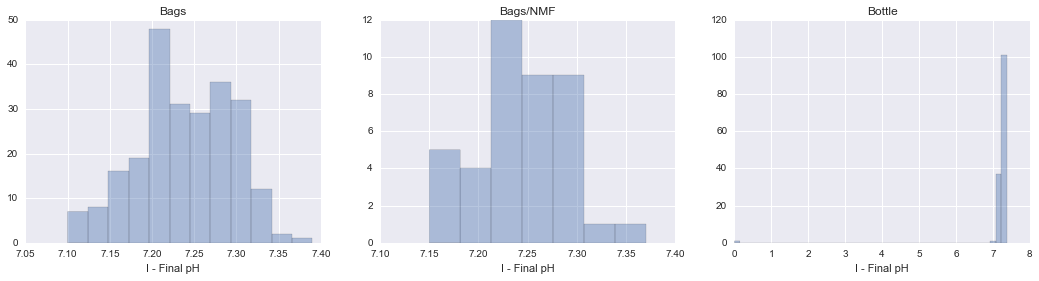

In [22]:
box_and_dist_graphs(raw_df,'I - Final pH')

There's this extreme outlier that I'm pretty sure is an error. Let me remove it from the dataset.

In [23]:
raw_df['I - Final pH'].sort_values() # index number 341 is the culprit
print 'Data length before dropping observation:',len(raw_df)
raw_df2 = raw_df[raw_df['I - Final pH'] != 0] # keep incrementing the raw_dfX number so I won't harm my orignal raw_df
print 'Data length after dropping observation:',len(raw_df2)

Data length before dropping observation: 422
Data length after dropping observation: 421


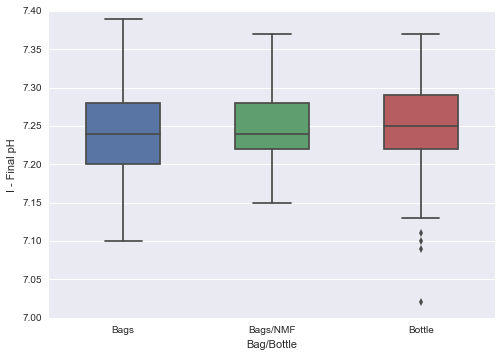

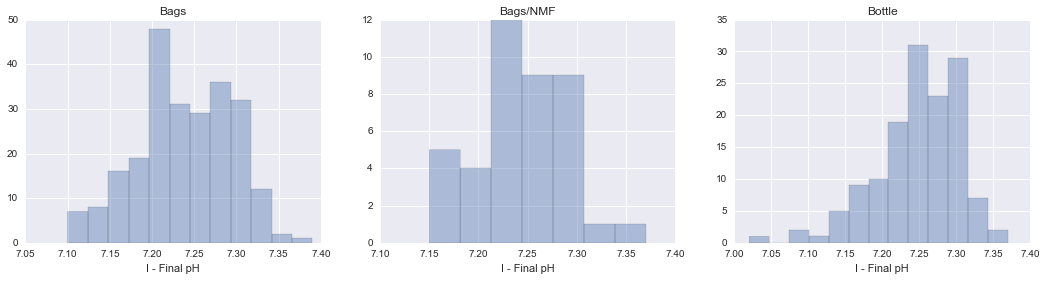

In [24]:
box_and_dist_graphs(raw_df2,'I - Final pH')

## I - Aging

In [275]:
# box_and_dist_graphs(raw_df2,'I - Aging')

In [276]:
raw_df2['I - Aging'].sort_values(ascending=False)
raw_df2 = raw_df2[~raw_df2.index.isin([380,369,370])]

In [277]:
# box_and_dist_graphs(raw_df2,'I - Aging')

## II+III After Alc pH

In [278]:
# box_and_dist_graphs(raw_df2,'II+III After Alc pH')

## II+III After Alc Titer

In [279]:
# box_and_dist_graphs(raw_df2,'II+III After Alc Titer')

## II+III - Final pH

In [280]:
# box_and_dist_graphs(raw_df2,'II+III - Final pH')

Need to take out that outlier

In [281]:
raw_df2[raw_df2['Bag/Bottle']=='Bottle']['II+III - Final pH'].sort_values(ascending=False) # pH value is 1004.00, index 286
print 'Before removing outlier, length of raw_df2:',len(raw_df2)
raw_df3 = raw_df2[raw_df2['II+III - Final pH'] != 1004.00]
print 'After removing outlier, length of raw_df3:',len(raw_df3)

Before removing outlier, length of raw_df2: 418
After removing outlier, length of raw_df3: 417


In [282]:
raw_df3['II+III - Final pH'].sort_values(ascending=True)
raw_df3 = raw_df3[~raw_df3.index.isin([168])]
# box_and_dist_graphs(raw_df3,'II+III - Final pH')

## II+III - Aging

In [283]:
# box_and_dist_graphs(raw_df3,'II+III - Aging')

In [284]:
raw_df3['II+III - Aging'].sort_values(ascending=False)
raw_df3 = raw_df3[~raw_df3.index.isin([381])]
# box_and_dist_graphs(raw_df3,'II+III - Aging')

## II+III Paste Wt

In [285]:
# box_and_dist_graphs(raw_df3,'II+III Paste Wt')

In [286]:
raw_df3['II+III Paste Wt'].sort_values(ascending=True)
# Index 154 and the value is 498
print 'Before removing outlier, length of raw_df3:',len(raw_df3)
raw_df4 = raw_df3[raw_df3['II+III Paste Wt'] != 498]
print 'After removing outlier, length of raw_df4:',len(raw_df4)

Before removing outlier, length of raw_df3: 415
After removing outlier, length of raw_df4: 414


In [287]:
# box_and_dist_graphs(raw_df4,'II+III Paste Wt')

## Buffer 1 Amt

In [288]:
# box_and_dist_graphs(raw_df4,'Buffer 1 Amt')

## Extract - Final pH

In [289]:
# box_and_dist_graphs(raw_df4,'Extract - Final pH')

In [290]:
raw_df4['Extract - Final pH'].sort_values(ascending=False)
raw_df4 = raw_df4[~raw_df4.index.isin([160])]
# box_and_dist_graphs(raw_df4,'Extract - Final pH')

## Extract - Aging

In [291]:
# box_and_dist_graphs(raw_df4,'Extract - Aging')

In [292]:
raw_df4['Extract - Aging'].sort_values(ascending=False)
raw_df4 = raw_df4[~raw_df4.index.isin([342])]
# box_and_dist_graphs(raw_df4,'Extract - Aging')

## G - Init pH

In [293]:
# box_and_dist_graphs(raw_df4,'G - Init pH')

In [294]:
raw_df4['G - Init pH'].sort_values(ascending=True)
# index 276 and value is 0.00
print 'Before removal:', len(raw_df4)
raw_df5= raw_df4[raw_df4['G - Init pH'] != 0.0]
print 'After removal:', len(raw_df5)

Before removal: 412
After removal: 411


In [295]:
raw_df5['G - Init pH'].sort_values(ascending=True)
raw_df5 = raw_df5[~raw_df5.index.isin([214,186,329])]
# box_and_dist_graphs(raw_df5,'G - Init pH')

## G - titer

In [296]:
# box_and_dist_graphs(raw_df5,'G - titer')

In [297]:
raw_df5['G - titer'].sort_values(ascending=True)
# outliers are index 83,93,150
print 'Before removal:',len(raw_df5)
raw_df6 = raw_df5[~raw_df5['G - titer'].isin([0.15,0.17,0.18])]
print 'After removal:',len(raw_df6)

Before removal: 408
After removal: 405


In [298]:
# box_and_dist_graphs(raw_df6,'G - titer')

## G - Final pH

In [299]:
# box_and_dist_graphs(raw_df6,'G - Final pH')

In [300]:
raw_df6['G - Final pH'].sort_values(ascending=True)
print 'Before removal:',len(raw_df6)
raw_df7 = raw_df6[raw_df6['G - Final pH']!=0.00]
print 'After removal:',len(raw_df7)

Before removal: 405
After removal: 401


In [301]:
# box_and_dist_graphs(raw_df7,'G - Final pH')

## G - Aging

In [302]:
# box_and_dist_graphs(raw_df7,'G - Aging')

## TD_CT

In [303]:
# box_and_dist_graphs(raw_df7,'TD_CT')

## FrI_PPT_CT

In [304]:
# box_and_dist_graphs(raw_df7,'FrI_PPT_CT')

## FrII_PPT_CT

In [305]:
# box_and_dist_graphs(raw_df7,'FrII_PPT_CT')

## V13_Sep_CT

In [306]:
# box_and_dist_graphs(raw_df7,'V13_Sep_CT')

In [307]:
raw_df7['V13_Sep_CT'].sort_values(ascending=True)
print 'Before removal:',len(raw_df7)
raw_df8 = raw_df7[raw_df7['V13_Sep_CT'] != -16.038611111172941]
print 'After removal:',len(raw_df8)

Before removal: 401
After removal: 400


In [308]:
# box_and_dist_graphs(raw_df8,'V13_Sep_CT')

## Ext_PPT_CT

In [309]:
# box_and_dist_graphs(raw_df8,'Ext_PPT_CT')

There are still issues with this feature's data set. I will ignore this feature for now.

## G_PPT_CT

In [310]:
# box_and_dist_graphs(raw_df8,'G_PPT_CT')

## Diluted % Efficiency
This can also be the study's target

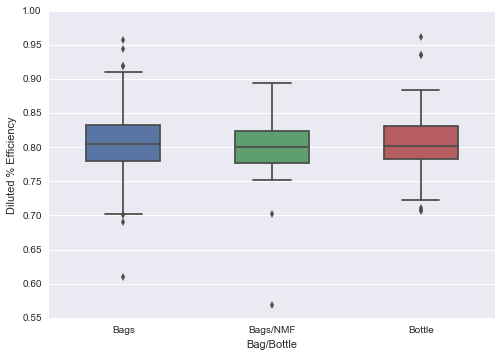

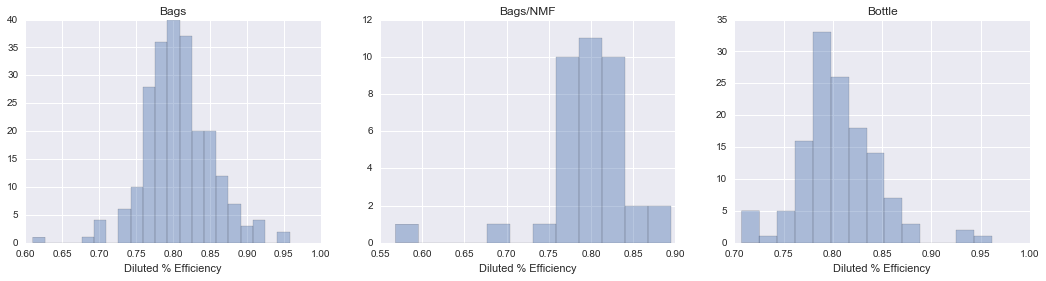

In [311]:
box_and_dist_graphs(raw_df8,'Diluted % Efficiency')

## Yield CP (WT)
This is the study's target.

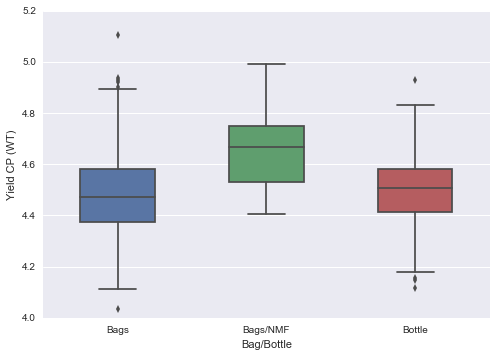

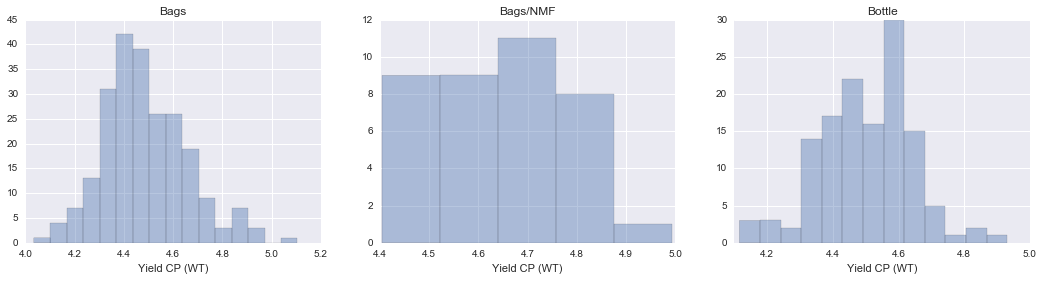

In [312]:
box_and_dist_graphs(raw_df8,'Yield CP (WT)')

Let's see if our yield is significantly different purely based on our raw material containers. Let's run a One-Way ANOVA test.

In [313]:
colors = []
for i in raw_df8['Year']:
    if i == '2014':
        colors.append('r')
    if i == '2015':
        colors.append('g')
    if i == '2016':
        colors.append('b')
# plt.scatter(x=range(len(raw_df8)),y=raw_df8['Yield CP (WT)'], c = colors)
# plt.title('Yield CP from 2014 to 2016')

In [314]:
bags_yield = raw_df8[raw_df8['Bag/Bottle']=='Bags']['Yield CP (WT)']
nmf_yield = raw_df8[raw_df8['Bag/Bottle']=='Bags/NMF']['Yield CP (WT)']
bottles_yield = raw_df8[raw_df8['Bag/Bottle']=='Bottle']['Yield CP (WT)']
print 'F-Statistic:',spStats.f_oneway(bags_yield,nmf_yield,bottles_yield)[0]
print 'P-Value:',spStats.f_oneway(bags_yield,nmf_yield,bottles_yield)[1]

F-Statistic: 16.7056955795
P-Value: 1.08140875166e-07


We can reject the null hypothesis and assume that containers have different yields.

# Features Selection
Now that we have a final cleaned dataframe that we can work with, let's look at selecting features to be used to model our target.

In [315]:
processed_df = copy.deepcopy(raw_df8)
processed_df.reset_index(drop=True,inplace=True)
len(processed_df)

400

In [316]:
# plt.figure(figsize=(15,10))
# sns.heatmap(processed_df.corr())

There are so many features, and some are highly correlated with others. Not exactly sure how best to use corr() to help choose features. Since I have domain knowledge on the dataset, I will start with the following features.

In [317]:
feature_cols = ['Bag/Bottle',
                'Total Protein (g/dL)',
                'CUNO Filt (kg)',
                'VP (L)',
                'Diluted CPP (kg)',
                'CPP IgG before Fr1',
                'Cuno IgG FP6',
                'I - Final pH',
                'I - Aging',
                'II+III After Alc pH',
                'II+III After Alc Titer',
                'II+III - Final pH',
                'II+III - Aging',
                'II+III Paste Wt',
                'Buffer 1 Amt',
                'Extract - Final pH',
                'Extract - Aging',
                'G - Init pH',
                'G - titer',
                'G - Final pH',
                'G - Aging',
                'TD_CT',
                'FrI_PPT_CT',
                'FrII_PPT_CT',
                'V13_Sep_CT',
                'G_PPT_CT',
                'Diluted % Efficiency',
                'Yield CP (WT)']

# plt.figure(figsize=(15,10))
# sns.heatmap(processed_df[feature_cols].corr())

In [318]:
numOfRows = 6
numOfCols = 5
x = 1
rValues_VS_Yield = {}

# figure,axes = plt.subplots(nrows=numOfRows,ncols=numOfCols,figsize=(20,20),sharex=False)
# for r in range(numOfRows):
#     for c in range(numOfCols):
#         if x <len(feature_cols):
#             sns.regplot(data=processed_df,x=feature_cols[x],y='Yield CP (WT)',ax=axes[r,c])
#             rValues_VS_Yield[feature_cols[x]] = spStats.pearsonr(processed_df['Yield CP (WT)'],processed_df[feature_cols[x]]) 
#             x = x + 1
#         else:
#             pass

In [319]:
numOfRows = 6
numOfCols = 5

x = 1
rValues_VS_Yield = {}
# figure,axes = plt.subplots(nrows=numOfRows,ncols=numOfCols,figsize=(20,20),sharex=False)
# for r in range(numOfRows):
#     for c in range(numOfCols):
#         if x <len(feature_cols):
#             sns.regplot(data=processed_df,x=feature_cols[x],y='Diluted % Efficiency',ax=axes[r,c])
#             rValues_VS_Yield[feature_cols[x]] = spStats.pearsonr(processed_df['Diluted % Efficiency'],processed_df[feature_cols[x]]) 
#             x = x + 1
#         else:
#             pass

# Conclusion
Most of this notebook is on data cleaning and coming up with a clean data set to work with. Some initial feature selection is conducted, but I will do most of the featuring in the next notebook. For now, exploratory analysis is done and I will export the clean data set into a file.

In [320]:
processed_df.to_excel('processed_data.xlsx')